# Homework 2

**The following notebook is meant to help you work through Problems 1 and 3 on Homework 2. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.patches as mpatches
from scipy.special import expit as sigmoid
from scipy.special import softmax
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvn

In [2]:
# loading data

# data for Problem 1
t_obs, y_obs = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

# added for 1.5
t_obs_alt, y_obs_alt = np.genfromtxt("data/planet-obs-alternate.csv", delimiter = ',', 
                                     usecols = (1, 2), skip_header=1).T
t_obs_alt = np.split(t_obs_alt, 10)
y_obs_alt = np.split(y_obs_alt.reshape(-1, 1), 10)

# data for Problem 3
data = pd.read_csv("data/hr.csv")
mapper = {
    "Dwarf": 0,
    "Giant": 1,
    "Supergiant": 2
}
data['Type'] = data['Type'].map(mapper)

X_stars = data[['Magnitude', 'Temperature']].values
y_stars = data['Type'].values

from T2_P1_TestCases import test_p1
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

In [3]:
print("Ratio of observed / not observed in alternate dataset: " + str(round(np.mean(y_obs_alt), 3)))
print("Ratio of observed / not observed in original dataset: " + str(round(np.mean(y_obs), 3)))

Ratio of observed / not observed in alternate dataset: 0.677
Ratio of observed / not observed in original dataset: 0.517


# Problem 1

## Problem 1 Subpart 1

In [4]:
def basis1(t):
    return np.stack([np.ones(len(t)), t], axis=1)

def basis2(t):
    """
    Transform t into basis [1, t, t^2]

    :param t: a 1D numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 3)
    """
    basis = np.column_stack((np.ones(len(t)), t, t**2))
    return basis

def basis3(t):
    """
    Transform t into basis [1, t, t^2, t^3, t^4, t^5]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 6)
    """
    basis = np.column_stack((np.ones(len(t)), t, t**2, t**3, t**4, t**5))
    return basis

In [5]:
class LogisticRegressor:
    def __init__(self, eta, runs):
        self.eta = eta # Learning rate, set to 0.001
        self.runs = runs # Numer of iterations, set to 10,000
        self.W = None

    def fit(self, x, y, w_init):
        """
        Optimize the weights W to minimize the negative log-likelihood by using gradient descent

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :param y: a 2D numpy array of output values. Shape is (n x 1)
        :param w_init: a 2D numpy array that initializes the weights. Shape is (n x 1)
        :return: None
        """
        # Keep this for the autograder
        self.W = w_init
        for _ in range(self.runs):
            y_pred = sigmoid(np.dot(x, self.W))
            gradient = np.dot(x.T, (y_pred - y)) / len(x)
            self.W -= self.eta * gradient

    def predict(self, x):
        """
        Predict classification probability of transformed input x
        
        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :return: a 2D numpy array of predicted probabilities given current weights. Shape should be (n x 1)
        """
        return sigmoid(np.dot(x, self.W))

In [6]:
test_p1(LogisticRegressor, basis1, basis2, basis3)

Your test case results are, for basis 1, 2, and 3 respectively: Pass Pass Pass


Note: Students have reported local issues with passing the basis 3 test case. Try running on Google Colab if only basis 3 test is failing.  

## Plotting Functions for Problem 1, Subpart 2

In [7]:
# Function to visualize prediction lines
# Takes as input last_x, last_y, [list of models], basis function, title
# last_x and last_y should specifically be the dataset that the last model
# in [list of models] was trained on
def visualize_prediction_lines(last_x, last_y, models, basis, title):
    # Plot setup
    green = mpatches.Patch(color='green', label='Ground truth model')
    black = mpatches.Patch(color='black', label='Mean of learned models')
    purple = mpatches.Patch(color='purple', label='Model learned from displayed dataset')
    # plt.legend(handles=[green, black, purple], loc='lower right')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.axis([0, 6, -.1, 1.1]) # Plot ranges

    # Plot dataset that last model in models (models[-1]) was trained on
    cmap = c.ListedColormap(['r', 'b'])
    plt.scatter(last_x, last_y, c=last_y, cmap=cmap, linewidths=1, edgecolors='black')

    # Plot models
    X_pred = np.linspace(0, 6, 1000)
    X_pred_transformed = basis(X_pred)

    ## Ground truth model
    plt.plot(X_pred, np.cos(1.1*X_pred + 1) * 0.4 + 0.5, 'g', linewidth=5)

    ## Individual learned logistic regressor models
    Y_hats = []
    for i in range(len(models)):
        model = models[i]
        Y_hat = model.predict(X_pred_transformed)
        Y_hats.append(Y_hat)
        if i < len(models) - 1:
            if i == 0:
                plt.plot(X_pred, Y_hat, 'red', linewidth=3)
            plt.plot(X_pred, Y_hat, linewidth=.3)
        else:
            plt.plot(X_pred, Y_hat, 'purple', linewidth=3)

    # Mean / expectation of learned models over all datasets
    plt.plot(X_pred, np.mean(Y_hats, axis=0), 'k', linewidth=5)

    plt.savefig(title + '.png')
    plt.show()

In [8]:
# You may find it helpful to modify this function for Problem 1, Subpart 4,
# but do not change the existing code--add your own variables
def plot_results(basis, title):
    eta = 0.001
    runs = 10000
    
    # Code for problem 1.4
    x01 = basis(np.array([0.1]))
    x32 = basis(np.array([3.2]))
    x50 = basis(np.array([5.0]))
    # Vectors to store predictions for t = 0.1 and t = 3.2 for 10 models
    y01 = []
    y32 = []
    y50 = []

    all_models = []
    for i in range(10): # iterate over 10 mini datasets
        x, y = t_obs[i], y_obs[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)
        
        # Code for problem 1.4
        y01.append(model.predict(x01))
        y32.append(model.predict(x32))
        y50.append(model.predict(x50))
        
    visualize_prediction_lines(x, y, all_models, basis, title)
    
    print("Predicted value for t = 0.1: " + str(y01[0]))
    print("Predicted value for t = 3.2: " + str(y32))
    print("Predicted value for t = 5.0: " + str(y50[0]))
    print("Variance of all models for t = 0.1: " + str(np.var(y01)))
    print("Variance of all models for t = 3.2: " + str(np.var(y32)))
    print("Variance of all models for t = 5.0: " + str(np.var(y50)))

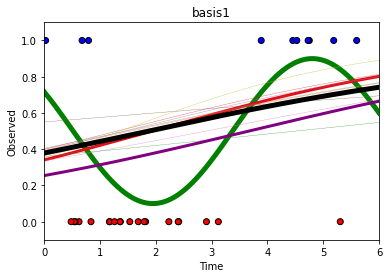

Predicted value for t = 0.1: [[0.34826597]]
Predicted value for t = 3.2: [array([[0.60743925]]), array([[0.60739082]]), array([[0.45829835]]), array([[0.64372313]]), array([[0.63107324]]), array([[0.62994375]]), array([[0.51759329]]), array([[0.61219045]]), array([[0.69686862]]), array([[0.46585616]])]
Predicted value for t = 5.0: [[0.74152709]]
Variance of all models for t = 0.1: 0.004982612148989635
Variance of all models for t = 3.2: 0.005660057219763854
Variance of all models for t = 5.0: 0.007829259341558089


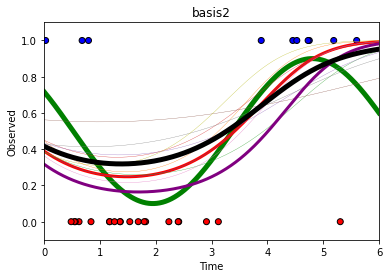

Predicted value for t = 0.1: [[0.36868564]]
Predicted value for t = 3.2: [array([[0.44202576]]), array([[0.52253817]]), array([[0.36100333]]), array([[0.55838572]]), array([[0.49109383]]), array([[0.60379355]]), array([[0.40085368]]), array([[0.54602461]]), array([[0.65042803]]), array([[0.28070066]])]
Predicted value for t = 5.0: [[0.92921727]]
Variance of all models for t = 0.1: 0.00455300931274591
Variance of all models for t = 3.2: 0.011807015051122482
Variance of all models for t = 5.0: 0.007684027204358443


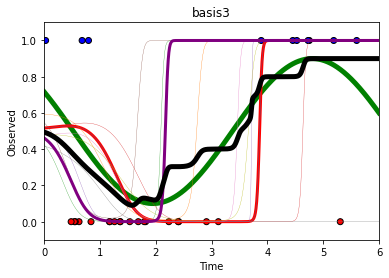

Predicted value for t = 0.1: [[0.51963619]]
Predicted value for t = 3.2: [array([[1.72086802e-06]]), array([[0.99999992]]), array([[1.]]), array([[1.08227229e-05]]), array([[9.74632428e-19]]), array([[1.]]), array([[0.00198724]]), array([[1.19290636e-24]]), array([[0.00666817]]), array([[1.]])]
Predicted value for t = 5.0: [[1.]]
Variance of all models for t = 0.1: 0.003403188441604656
Variance of all models for t = 3.2: 0.23931064419136497
Variance of all models for t = 5.0: 0.08999999991021124


In [9]:
plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

## Problem 1, Subpart 5

In [10]:
# You may find it helpful to modify this function for Problem 1, Subpart 4,
# but do not change the existing code--add your own variables
def plot_results(basis, title):
    eta = 0.001
    runs = 10000
    
    # Code for problem 1.4
    x01 = basis(np.array([0.1]))
    x32 = basis(np.array([3.2]))
    x50 = basis(np.array([5.0]))
    # Vectors to store predictions for t = 0.1 and t = 3.2 for 10 models
    y01 = []
    y32 = []
    y50 = []

    all_models = []
    for i in range(10): # iterate over 10 mini datasets
        x, y = t_obs_alt[i], y_obs_alt[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)
        
        # Code for problem 1.4
        y01.append(model.predict(x01))
        y32.append(model.predict(x32))
        y50.append(model.predict(x50))
        
    visualize_prediction_lines(x, y, all_models, basis, title)
    
    print("Predicted value for t = 0.1: " + str(y01[0]))
    print("Predicted value for t = 3.2: " + str(y32[0]))
    print("Predicted value for t = 5.0: " + str(y50[0]))
    print("Variance of all models for t = 0.1: " + str(np.var(y01)))
    print("Variance of all models for t = 3.2: " + str(np.var(y32)))
    print("Variance of all models for t = 5.0: " + str(np.var(y50)))

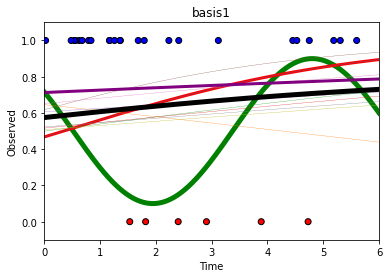

Predicted value for t = 0.1: [[0.47700938]]
Predicted value for t = 3.2: [[0.74638321]]
Predicted value for t = 5.0: [[0.85316042]]
Variance of all models for t = 0.1: 0.005837732239630753
Variance of all models for t = 3.2: 0.00822848829445331
Variance of all models for t = 5.0: 0.014124378357976312


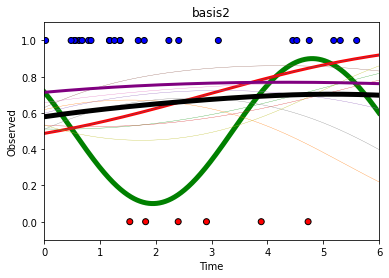

Predicted value for t = 0.1: [[0.49245403]]
Predicted value for t = 3.2: [[0.72609291]]
Predicted value for t = 5.0: [[0.86472281]]
Variance of all models for t = 0.1: 0.005309628271471565
Variance of all models for t = 3.2: 0.009547989507323221
Variance of all models for t = 5.0: 0.018747482348891915


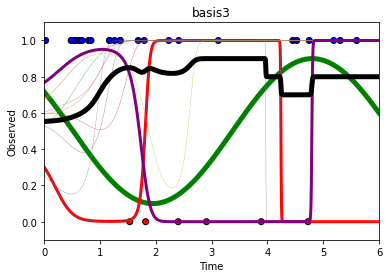

Predicted value for t = 0.1: [[0.24985704]]
Predicted value for t = 3.2: [[1.]]
Predicted value for t = 5.0: [[6.36223067e-160]]
Variance of all models for t = 0.1: 0.03081917716985469
Variance of all models for t = 3.2: 0.08999999999978393
Variance of all models for t = 5.0: 0.16


In [11]:
plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

# Problem 3

In [12]:
class GaussianGenerativeModel:
    def __init__(self, is_shared_covariance=False):
        self.is_shared_covariance = is_shared_covariance

    def fit(self, X, y):
        """
        Compute the means and (shared) covariance matrix of the data. Compute the prior over y.
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """
        classes = np.unique(y) # [0, 1, 2]
        self.means = []
        self.priors = [0] * len(classes)
        
        # Cov matrix if it's shared between classes
        self.shared_covariance = np.zeros((2,2))
        
        # Keep separate cov matrix otherwise
        self.covariances = []
        
        for cls in classes:
            # Get the x values in the class
            X_cls = X[y == cls]
            
            # Compute mu_k for each class and append to self.means
            self.means.append(np.mean(X_cls, axis=0))
            
            # Compute covariance matrix, sigma. 
            # TODO: Default np.cov divides by n-1 instead of n, should I multiply by len(X) / len(X)-1? 
            if self.is_shared_covariance:
                # Linear combo of the within-class covariances based on ratio of points in that class
                self.shared_covariance += len(X_cls) / len(X) * np.cov(X_cls, rowvar=False)
            else:
                self.covariances.append(np.cov(X_cls, rowvar=False))
            
            # Compute pi: take the number of elements in X / n
            self.priors[cls] = len(X_cls) / len(X)

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        preds = []
        for cls in range(len(self.means)): # for each class
            # Get the cov matrix
            if self.is_shared_covariance:
                cov = self.shared_covariance
            else:
                cov = self.covariances[cls]
            # Make prediction using mvn pdf 
            preds.append(mvn.pdf(X_pred, self.means[cls], cov))
        preds = np.array(preds)
        if preds.ndim == 1:
            preds = np.reshape(preds, (preds.shape[0], 1))
        # Return the argmax of your predictions
        return np.argmax(preds.T, axis=1)
        

    def negative_log_likelihood(self, X, y):
        """
        Given the data X, use previously calculated class means and covariance matrix to 
        calculate the negative log likelihood of the data
        """
        neg_ll = 0
        for x, cls in zip(X, y):
            # Get the cov matrix 
            if self.is_shared_covariance:
                cov = self.shared_covariance
            else:
                cov = self.covariances[cls]
            neg_ll += -np.log(multivariate_normal(x, self.means[cls], cov) * self.priors[cls])
        return neg_ll

In [13]:
class SoftmaxRegression:
    def __init__(self, eta, lam):
        self.eta = eta
        self.lam = lam
        self.W = None
        self.runs = 200000

    def fit(self, X, y):
        """
        Fit the weights W of softmax regression using gradient descent with L2 regularization
        Use the results from Problem 2 to find an expression for the gradient
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """
        # Bias trick - add column of ones to x 
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        
        # Initializing the weights (do not change!)
        # The number of classes is 1 + (the highest numbered class)
        num_classes = 1 + y.max()
        num_features = X.shape[1]
        self.W = np.ones((num_classes, num_features))
        
        # One-hot encode Y
        y = np.eye(num_classes)[y]
        
        # Gradient descent for 200,000 iterations
        for i in range(self.runs):
            y_pred = softmax(np.dot(X, self.W.T), axis=1)
            
            # Gradient with L2 regularization 
            gradient = np.dot((y_pred - y).T, X) + self.lam * self.W
            self.W -= self.eta * gradient

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        # Bias trick - add column of ones to x 
        X_pred = np.column_stack([np.ones(X_pred.shape[0]), X_pred]) 
        return np.argmax(np.dot(X_pred, self.W.T), axis=1)
    
    def predict_proba(self, X_pred):
        """    
        Predict classification probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Dwarf=index 0, Giant=index 1, Supergiant=index 2).
                 Shape should be (n x 3)
        """
        # Bias trick - add column of ones to x 
        X_pred = np.column_stack([np.ones(X_pred.shape[0]), X_pred]) 
        return softmax(np.dot(X_pred, self.W.T), axis=1)

In [14]:
class KNNClassifier:
    def __init__(self, k):
        self.X = None
        self.y = None
        self.K = k
        
    def fit(self, X, y):
        """
        In KNN, "fitting" can be as simple as storing the data, so this has been written for you.
        If you'd like to add some preprocessing here without changing the inputs, feel free,
        but this is completely optional.
        """
        self.X = X
        self.y = y

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        preds = []
        for x in X_pred:
            distances = []
            for x_i, y_i in zip(self.X, self.y):
                # Use distance formula specified in part e
                distances.append(((x[0] - x_i[0])**2/9) + (x[1] - x_i[1])**2)
                
            # List of tuples, (distance, y_class)
            distances_and_y = [(d, y) for d, y in zip(distances, self.y)]
            
            # Sort the list of tuples based on distance 
            distances_and_y.sort(key=lambda z: z[0])
            
            # Get the k nearest neighbors
            knn = distances_and_y[:self.K]
            
            # Count the number of classes and append the class that appears most often to preds
            preds.append(np.argmax(np.bincount([y for d, y in knn])))
        return np.array(preds)

In [15]:
def phi(X):
    """
    Transform [x_1, x_2] into basis [ln(x_1 + 10), x_2^2]

    :param t: a 2D numpy array of values to transform. Shape is (n x 2)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 2)
    """
    c1 = np.log(X[:, 0]+10)
    c2 = (X[:, 1])**2
    return np.stack([c1, c2], axis = 1)

## Plotting Function for Problem 3, Subpart 1

In [16]:
# Visualize the decision boundary that a model produces
def visualize_boundary(model, X, y, title, basis=None, width=2):
    # Create a grid of points
    x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
    y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T
    
    if basis is not None:
        X_pred = basis(X_pred)

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Magnitude')
    plt.ylabel('Temperature')
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Dwarf')
    blue = mpatches.Patch(color='blue', label='Giant')
    green = mpatches.Patch(color='green', label='Supergiant')
    plt.legend(handles=[red, blue, green])

    # Saving the image to a file, and showing it as well
    plt.savefig(title + '.png')
    plt.show()

## Problem 3, Subpart 1

<ipython-input-16-d59a25f482f4>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)


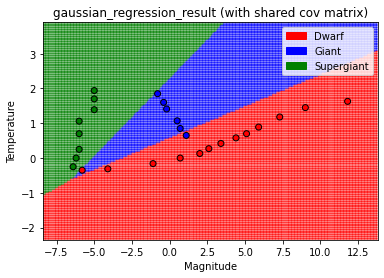

In [17]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
gaussian_model = GaussianGenerativeModel(is_shared_covariance=True)
gaussian_model.fit(X_stars, y_stars)
visualize_boundary(model=gaussian_model,
                   X=X_stars,
                   y=y_stars,
                   title='gaussian_regression_result (with shared cov matrix)',
                   basis=None)

<ipython-input-16-d59a25f482f4>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)


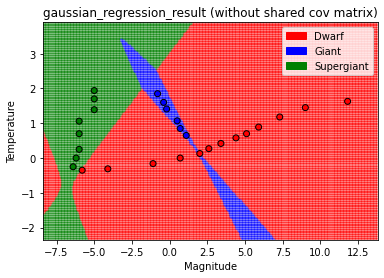

In [18]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
gaussian_model = GaussianGenerativeModel(is_shared_covariance=False)
gaussian_model.fit(X_stars, y_stars)
visualize_boundary(model=gaussian_model,
                   X=X_stars,
                   y=y_stars,
                   title='gaussian_regression_result (without shared cov matrix)',
                   basis=None)

<ipython-input-16-d59a25f482f4>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)


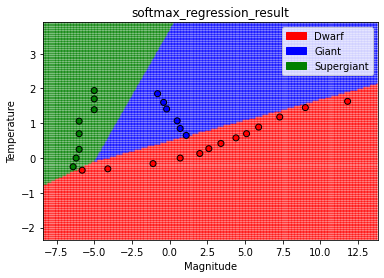

In [19]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
softmax_model = SoftmaxRegression(eta=0.001, lam=0.001)
softmax_model.fit(X_stars, y_stars)
visualize_boundary(model=softmax_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_regression_result',
                   basis=None)

<ipython-input-16-d59a25f482f4>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)


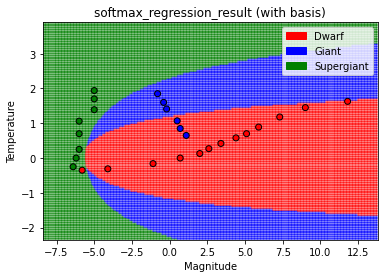

In [20]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
basis_model = SoftmaxRegression(eta=0.001, lam=0.001)
basis_model.fit(phi(X_stars), y_stars)
visualize_boundary(model=basis_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_regression_result (with basis)',
                   basis=phi)

<ipython-input-16-d59a25f482f4>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)


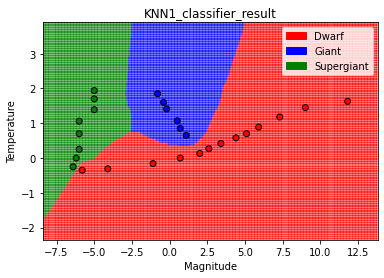

In [21]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
knn1_model = KNNClassifier(k=1)
knn1_model.fit(X_stars, y_stars)
visualize_boundary(model=knn1_model,
                   X=X_stars,
                   y=y_stars,
                   title='KNN1_classifier_result',
                   basis=None)

<ipython-input-16-d59a25f482f4>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)


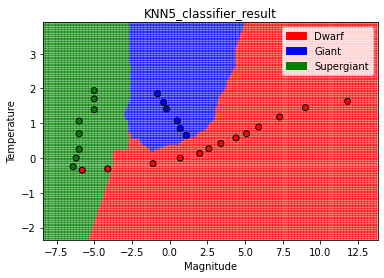

In [22]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
knn5_model = KNNClassifier(k=5)
knn5_model.fit(X_stars, y_stars)
visualize_boundary(model=knn5_model,
                   X=X_stars,
                   y=y_stars,
                   title='KNN5_classifier_result',
                   basis=None)

In [23]:
# test your models by passing your fitted models into the functions below
# softmax_model is an instance of class SoftmaxRegression fitted to data X_stars, y_stars
# basis_model is an instance of class SoftmaxRegression fitted to data phi(X_stars), y_stars
# knn1_model is an instance of class KNNClassifier with parameter k=1
# knn5_model is an instance of class KNNClassifier with parameter k=5
test_p3_softmax(softmax_model, basis_model)
test_p3_knn(knn1_model, knn5_model)

Passed softmax regression tests


AttributeError: 'KNNClassifier' object has no attribute 'distance'

In [ ]:
star = np.array([[3, -2]])

gaussian_model_shared = GaussianGenerativeModel(is_shared_covariance=True)
gaussian_model_shared.fit(X_stars, y_stars)

gaussian_model = GaussianGenerativeModel(is_shared_covariance=False)
gaussian_model.fit(X_stars, y_stars)

In [ ]:
print(gaussian_model_shared.predict(star))

In [ ]:
softmax_model = SoftmaxRegression(eta=0.001, lam=0.001)
softmax_model.fit(X_stars, y_stars)

basis_model = SoftmaxRegression(eta=0.001, lam=0.001)
basis_model.fit(phi(X_stars), y_stars)

knn_model_1 = KNNClassifier(k=1)
knn_model_1.fit(X_stars, y_stars)

knn_model_5 = KNNClassifier(k=5)
knn_model_5.fit(X_stars, y_stars)

In [ ]:
print("Softmax: ", softmax_model.predict_proba(star))
print("Softmax: ", softmax_model.predict(star))
print("Basis: ", basis_model.predict_proba(phi(star)))
print("Basis: ", basis_model.predict(phi(star)))
print("kNN k=1: ", knn_model_1.predict(star))
print("kNN k=5: ", knn_model_5.predict(star))